In [1]:
import pandas as pd
import numpy as np

In [2]:
price_df = pd.read_csv('hyundai.csv')

In [3]:
price_df.head()

,date,price
0,2014-12-22,171000
1,2014-12-23,171500
2,2014-12-24,175000
3,2014-12-26,174500
4,2014-12-29,171500


In [4]:
price_df.describe()

,price
count,2400.000000
mean,165905.083333
std,40447.961813
min,65900.000000
25%,135500.000000
50%,159000.000000
75%,188550.000000
max,298000.000000


In [5]:
price_df.set_index(['date'],inplace=True)

In [6]:
n = 20
sigma = 2

In [7]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['price'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['price'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['price'].rolling(n).std() # 하단 밴드
    return bb

In [8]:
bollinger = bollinger_band(price_df, n, sigma)

In [9]:
bollinger.head(21)

,price,center,ub,lb
date,,,,
2014-12-22,171000,NaN,NaN,NaN
2014-12-23,171500,NaN,NaN,NaN
2014-12-24,175000,NaN,NaN,NaN
2014-12-26,174500,NaN,NaN,NaN
2014-12-29,171500,NaN,NaN,NaN
2014-12-30,169000,NaN,NaN,NaN
2015-01-02,169000,NaN,NaN,NaN
2015-01-05,168000,NaN,NaN,NaN
2015-01-06,164500,NaN,NaN,NaN


In [10]:
base_date = '2016-01-01'

In [11]:
sample = bollinger.loc[base_date:]
sample.head()

,price,center,ub,lb
date,,,,
2016-01-04,144000,151100.0,155874.934555,146325.065445
2016-01-05,143500,150625.0,156391.281297,144858.718703
2016-01-06,140000,150050.0,157497.359122,142602.640878
2016-01-07,137500,149400.0,158716.651759,140083.348241
2016-01-08,136500,148725.0,159672.121708,137777.878292


In [12]:
def create_trade_book(sample):
    book = sample[['price']].copy()
    book['trade'] = ''
    return (book)    

In [13]:
book = create_trade_book(sample)

In [14]:
book.head()

,price,trade
date,,
2016-01-04,144000,
2016-01-05,143500,
2016-01-06,140000,
2016-01-07,137500,
2016-01-08,136500,


In [15]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'price'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'price']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'price'] and sample.loc[i, 'price'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [16]:
book = tradings(sample,book)

In [17]:
book.tail(10)

,price,trade
date,,
2024-09-09,229500,buy
2024-09-10,231000,buy
2024-09-11,223500,buy
2024-09-12,232000,buy
2024-09-13,237000,buy
2024-09-19,246000,buy
2024-09-20,250500,buy
2024-09-23,249000,buy
2024-09-24,253000,buy


In [24]:
rtn = 1.0
book['return'] = 1
buy = 144000
sell = 0.0
book['return'] = book['return'].astype(float)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'price']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'price']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

book.loc[i, 'return'] = float(rtn)

청산일 :  2016-02-17 long 진입가격 :  144000  |  long 청산가격 :  147000  | return: 1.0208
진입일 :  2016-05-04 long 진입가격 :  139000
청산일 :  2016-09-05 long 진입가격 :  139000  |  long 청산가격 :  139000  | return: 1.0
진입일 :  2016-10-10 long 진입가격 :  133500
청산일 :  2016-12-08 long 진입가격 :  133500  |  long 청산가격 :  142000  | return: 1.0637
진입일 :  2017-01-25 long 진입가격 :  142000
청산일 :  2017-03-20 long 진입가격 :  142000  |  long 청산가격 :  156500  | return: 1.1021
진입일 :  2017-07-07 long 진입가격 :  151500
청산일 :  2017-09-26 long 진입가격 :  151500  |  long 청산가격 :  147500  | return: 0.9736
진입일 :  2017-12-11 long 진입가격 :  150000
청산일 :  2018-01-19 long 진입가격 :  150000  |  long 청산가격 :  162000  | return: 1.08
진입일 :  2018-03-29 long 진입가격 :  143500
청산일 :  2018-07-25 long 진입가격 :  143500  |  long 청산가격 :  130500  | return: 0.9094
진입일 :  2018-10-08 long 진입가격 :  122000
청산일 :  2018-12-12 long 진입가격 :  122000  |  long 청산가격 :  118500  | return: 0.9713
진입일 :  2019-02-14 long 진입가격 :  121500
청산일 :  2019-04-08 long 진입가격 :  121500  |  long 청산가격 :  128000

In [25]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 144000
    sell = 0.0
    book['return'] = book['return'].astype(float)
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'price']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'price']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

청산일 :  2016-02-17 long 진입가격 :  144000  |  long 청산가격 :  147000  | return: 1.0208
진입일 :  2016-05-04 long 진입가격 :  139000
청산일 :  2016-09-05 long 진입가격 :  139000  |  long 청산가격 :  139000  | return: 1.0
진입일 :  2016-10-10 long 진입가격 :  133500
청산일 :  2016-12-08 long 진입가격 :  133500  |  long 청산가격 :  142000  | return: 1.0637
진입일 :  2017-01-25 long 진입가격 :  142000
청산일 :  2017-03-20 long 진입가격 :  142000  |  long 청산가격 :  156500  | return: 1.1021
진입일 :  2017-07-07 long 진입가격 :  151500
청산일 :  2017-09-26 long 진입가격 :  151500  |  long 청산가격 :  147500  | return: 0.9736
진입일 :  2017-12-11 long 진입가격 :  150000
청산일 :  2018-01-19 long 진입가격 :  150000  |  long 청산가격 :  162000  | return: 1.08
진입일 :  2018-03-29 long 진입가격 :  143500
청산일 :  2018-07-25 long 진입가격 :  143500  |  long 청산가격 :  130500  | return: 0.9094
진입일 :  2018-10-08 long 진입가격 :  122000
청산일 :  2018-12-12 long 진입가격 :  122000  |  long 청산가격 :  118500  | return: 0.9713
진입일 :  2019-02-14 long 진입가격 :  121500
청산일 :  2019-04-08 long 진입가격 :  121500  |  long 청산가격 :  128000

<Axes: xlabel='date'>

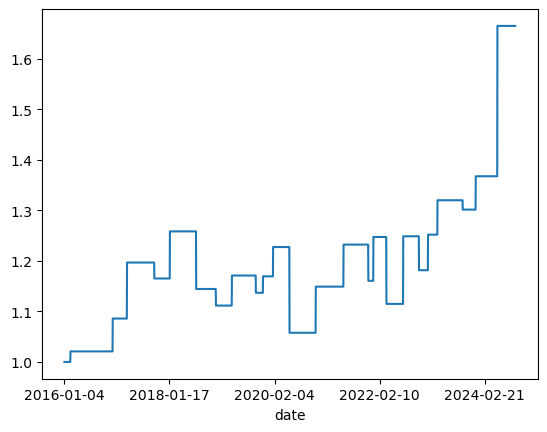

In [26]:
print(returns(book))
book['acc return'].plot()

In [27]:
book.tail()

,price,trade,return,acc return
date,,,,
2024-09-19,246000,buy,1.0,1.664902
2024-09-20,250500,buy,1.0,1.664902
2024-09-23,249000,buy,1.0,1.664902
2024-09-24,253000,buy,1.0,1.664902
2024-09-25,254500,buy,1.0,1.664902
